In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from highlight_text import ax_text, fig_text
import matplotlib.patheffects as path_effects

df = pd.read_csv('WHR2024.csv')

# rename column
len_to_remove = len('Explained by: ')
for col in df.columns:
    if 'Explained by: ' in col:
        new_name = col[len_to_remove:]
        df[new_name] = df[col]
        df.drop(col, axis=1, inplace=True)

# create part of each explainer
not_explainers = ['Country name', 'Ladder score',
                  'upperwhisker', 'lowerwhisker', 'total']
explainers = ['Dystopia + residual', 'Log GDP per capita', 'Social support',
              'Healthy life expectancy', 'Freedom to make life choices',
              'Generosity', 'Perceptions of corruption']
for explainer in explainers:
    df['share_'+explainer] = df[explainer]/df['Ladder score']*100

# open and merge with geo data
world = gpd.read_file(
    "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
europe = world[world['CONTINENT'] == 'Europe']
data = europe.merge(
    df, how='left',
    left_on='NAME',
    right_on='Country name'
)
europe.columns
data = data[['geometry']+df.columns.to_list()]
data = data[data['Country name'] != 'Russia']
data.dropna(inplace=True)

data.to_csv('happiness.csv', index=False)
data.sample(3)

,geometry,Country name,Ladder score,upperwhisker,lowerwhisker,Dystopia + residual,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,share_Dystopia + residual,share_Log GDP per capita,share_Social support,share_Healthy life expectancy,share_Freedom to make life choices,share_Generosity,share_Perceptions of corruption
1,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",Norway,7.302,7.389,7.215,1.586,1.952,1.517,0.704,0.835,0.224,0.484,21.720077,26.732402,20.775130,9.641194,11.435223,3.067653,6.628321
26,"MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...",Italy,6.324,6.436,6.211,1.777,1.800,1.328,0.720,0.513,0.112,0.074,28.099304,28.462998,20.999367,11.385199,8.111954,1.771031,1.170145
33,"POLYGON ((15.01700 51.10667, 15.49097 50.78473...",Czechia,6.822,6.903,6.741,1.858,1.783,1.511,0.638,0.787,0.177,0.068,27.235415,26.136030,22.148930,9.352096,11.536206,2.594547,0.996775


In [28]:
type(data)

geopandas.geodataframe.GeoDataFrame

In [19]:
def create_gradient_colormap(color1, color2):
    colors = [color1, color2]
    cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)
    return cmap

def draw_arrow(tail_position, head_position, fig, invert=False):
    kw = dict(
        arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color="white")
    if invert:
        connectionstyle = "arc3,rad=-.5"
    else:
        connectionstyle = "arc3,rad=.5"
    a = FancyArrowPatch(tail_position, head_position,
                        connectionstyle=connectionstyle,
                        transform=fig.transFigure,
                        **kw)
    fig.patches.append(a)

def plot_map_on_ax(column, ax, cmap):
    data.plot(
        column=column,
        cmap=cmap,
        edgecolor='black', linewidth=0.4,
        ax=ax
    )
    ax.set_xlim(-13.8, 40)
    ax.set_ylim(32, 72)
    ax.axis('off')

def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]
pe = path_effect_stroke(linewidth=1, foreground="black")

In [4]:
colors = {
    'share_Generosity': ['#c9ada7', '#4a4e69'],
    'share_Perceptions of corruption': ['#fcbf49', '#d62828'],
    'share_Freedom to make life choices': ['#90e0ef', '#0077b6'],
    'share_Social support': ['#80ed99', '#38a3a5'],
}

background_col = '#22333b'

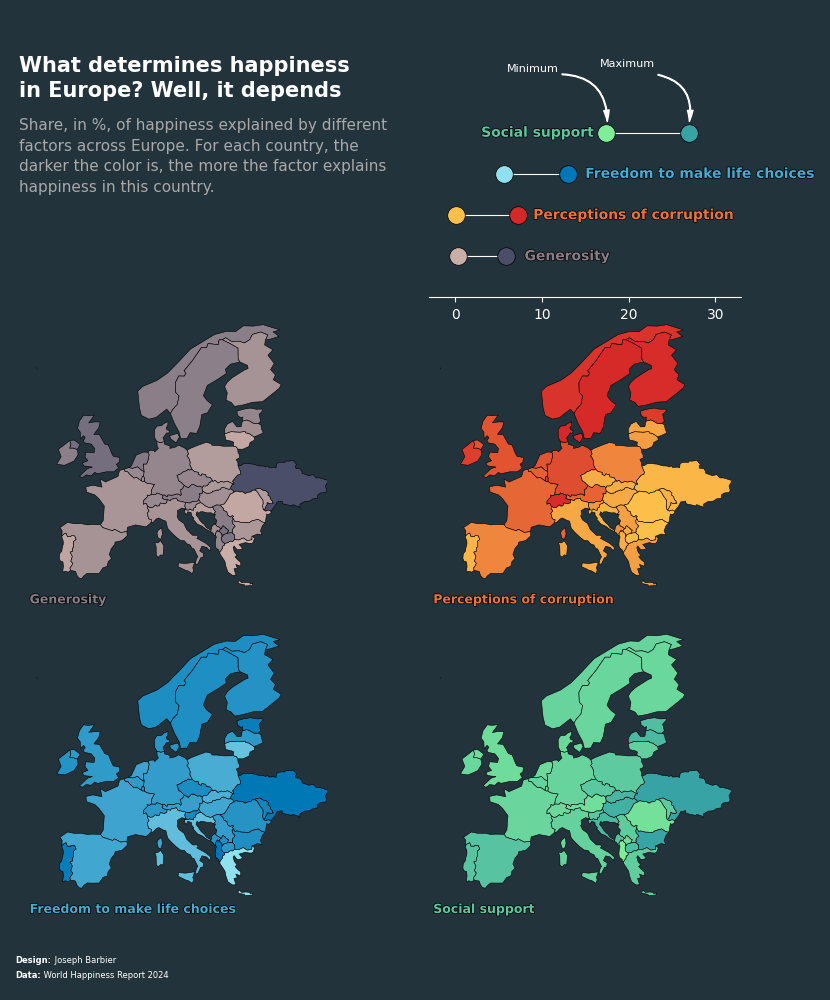

In [25]:
# initialize the figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
axs = axs.flatten()

# set background color
fig.set_facecolor(background_col)
axs[1].set_facecolor(background_col)

columns = [
    '','',
    'share_Generosity',
    'share_Perceptions of corruption',
    'share_Freedom to make life choices',
    'share_Social support'
]
annotations_pos = [
    '', '',
    [8, 0],
    [9, 1],
    [15, 2],
    [3, 3]
]
for i, (ax, column) in enumerate(zip(axs, columns)):

    # skip first two axes (on top of the maps)
    if i in [0,1]:
        continue

    cmap = create_gradient_colormap(colors[column][0], colors[column][1])
    plot_map_on_ax(column=column, ax=ax, cmap=cmap)

    ax_text(
        -15, 33,
        '<'+column[6:]+'>', 
        ha='left', va='center',
        fontsize=9, fontweight='bold',
        color=cmap(0.5),
        highlight_textprops=[
            {"path_effects": pe}
        ],
        ax=ax
    )

    # annotations on lollipop
    x, y = annotations_pos[i]
    ax_text(
        x, y,
        '<'+column[6:]+'>',
        ha='left', va='center',
        fontweight='bold',
        fontsize=10,
        color=cmap(0.5),
        highlight_textprops=[
            {"path_effects": pe}
        ],
        ax=axs[1]
    )

# Lollipop plot
min_max_df = data[columns[2:]].agg(['min', 'max']).T
for i, col in enumerate(columns[2:]):

    # colors
    min_color = colors[col][0]
    max_color = colors[col][1]

    subset = min_max_df.iloc[i].T
    axs[1].scatter(subset['min'], i, zorder=2,
                   s=160, edgecolor='black', linewidth=0.5, color=min_color)
    axs[1].scatter(subset['max'], i, zorder=2,
                   s=160, edgecolor='black', linewidth=0.5, color=max_color)

axs[1].hlines(
    y=range(4),
    xmin=min_max_df['min'],
    xmax=min_max_df['max'],
    color='white',
    linewidth=0.8,
    zorder=1
)
axs[1].spines[['right', 'top', 'left']].set_visible(False)
axs[1].set_xticks([0, 10, 20, 30, 40])
axs[1].spines['bottom'].set_color('white')
axs[1].tick_params(axis='x', colors='white')
axs[1].set_yticks([])
axs[1].set_ylim(-1, 6)
axs[1].set_xlim(-3, 33)

# remove top left axis
axs[0].set_axis_off()

# title and credit
text = """
<What determines happiness>
<in Europe? Well, it depends>


<Share, in %, of happiness explained by different>
<factors across Europe. For each country, the>
<darker the color is, the more the factor explains>
<happiness in this country.>
"""
ax_text(
    -0.02, 0.6,
    text,
    ha='left', va='center',
    fontsize=15,
    color='black',
    highlight_textprops=[
        {'fontweight': 'bold',
         'color': 'white'},
        {'fontweight': 'bold',
         'color': 'white'},

        {'color': 'darkgrey',
         'fontsize': 11},
        {'color': 'darkgrey',
         'fontsize': 11},
        {'color': 'darkgrey',
         'fontsize': 11},
        {'color': 'darkgrey',
         'fontsize': 11}
    ],
    ax=axs[0]
)
# title and credit
text = """
<Design:> Joseph Barbier
<Data:> World Happiness Report 2024
"""
ax_text(
    -17.6, 25,
    text,
    ha='left', va='center',
    fontsize=6,
    color='white',
    highlight_textprops=[
        {'fontweight': 'bold',
         'color': 'white'},
        {'fontweight': 'bold',
         'color': 'white'},
    ],
    ax=axs[4]
)

# reduce size and position of top right axe
axs[1].set_position([0.56, 0.68, 0.2, 0.1])

# legend arrows
draw_arrow((0.7, 0.92), (0.76, 0.87), fig=fig, invert=True)
draw_arrow((0.82, 0.92), (0.862, 0.87), fig=fig, invert=True)
ax_text(
    6, 4.7,
    'Minimum',
    fontsize=8,
    color='white',
    ax=axs[1]
)
ax_text(
    16.7, 4.8,
    'Maximum',
    fontsize=8,
    color='white',
    ax=axs[1]
)

# display the plot
plt.tight_layout()
fig.savefig('mutliple_maps.png', dpi=300, bbox_inches='tight')
plt.show()

## to change

- add labels of metrics on lollipop
- change colormap so that start and end colors are not white and black
- add annotations